In [1]:
import numpy as np
import pandas as pd
import pulp
import itertools
import folium
import openrouteservice
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from branca.element import Figure
from openrouteservice import convert
import matplotlib.pyplot as plt
import japanize_matplotlib
import sys
import time
import csv

zahyo = pd.read_csv("geo_loc_pos.csv")
idou_jikan = pd.read_csv("geo_loc_loc_time.csv")

num_places_time = len(idou_jikan)
customer_count = len(zahyo) #場所の数（id=0はdepot）
lim_day_count = 100 #何日かlim
lim_time_capacity = 60*60*4 #一日に使える時間

In [2]:
#顧客緯度・経度設定
df_data = pd.DataFrame(zahyo.drop("地名",axis=1))


print(df_data)

    latitude   longitude  stay_time
0  35.631040  139.786485         60
1  35.629763  139.793982         60
2  35.649380  139.789728         60
3  35.619614  139.776940         60
4  35.632654  139.792974         60
5  35.635271  139.780359         60


In [3]:
df_prefecture = pd.read_csv("geo_loc_pos.csv")

def visualize_locations(df):
    f = folium.Figure(width=1000, height=500)

    # 初期表示の中心の座標を指定して地図を作成する。
    center_lat=df["latitude"][0]
    center_lon=df["longitude"][0]
    m = folium.Map([center_lat,center_lon],
                   zoom_start=13).add_to(f)
        
    # データフレームの全ての行のマーカーを作成する。
    for i in range(0,len(df)):
        folium.Marker(location=[df["latitude"][i],df["longitude"][i]]).add_to(m)
        
    return m
    
visualize_locations(df_prefecture)

In [4]:
with open("geo_loc_loc_time.csv", encoding="utf_8") as f:
    reader = csv.reader(f)
    loc_loc_time = [row for row in reader]

cost = [[0 for i in range(customer_count)] for j in range(customer_count)]
for i in range(num_places_time):
    cost[int(loc_loc_time[i+1][0])][int(loc_loc_time[i+1][1])] = float(loc_loc_time[i+1][2])
    cost[int(loc_loc_time[i+1][1])][int(loc_loc_time[i+1][0])] = float(loc_loc_time[i+1][2])
cost = np.array(cost)
cost

array([[   0. ,  710.3, 2052.8, 1319.1,  558.9,  733.2],
       [ 710.3,    0. , 2021.8, 1579.2,  319.5, 1274.5],
       [2052.8, 2021.8,    0. , 3210.6, 1759.8, 1614.8],
       [1319.1, 1579.2, 3210.6,    0. , 1711.2, 1664.2],
       [ 558.9,  319.5, 1759.8, 1711.2,    0. , 1111.1],
       [ 733.2, 1274.5, 1614.8, 1664.2, 1111.1,    0. ]])

<Axes: >

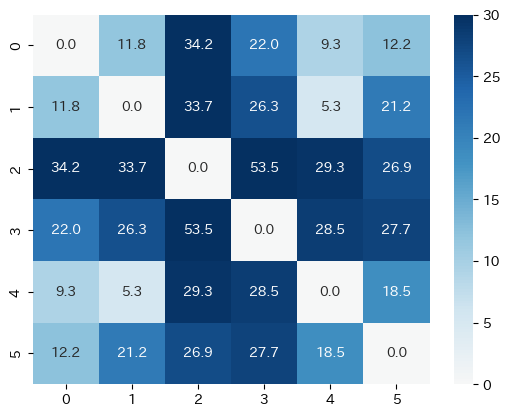

In [5]:
import seaborn as sns

sns.heatmap(cost/60, vmax=30, vmin=0, center=0, cmap='RdBu', annot=True, annot_kws={"size": 10},fmt=".1f")

In [10]:
for lim_day_count in range(lim_day_count+1):
    opt_TripY = pulp.LpProblem("CVRP", pulp.LpMinimize)
    X_ijk = [[[pulp.LpVariable("X%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(lim_day_count)]
            for j in range(customer_count)] for i in range(customer_count)]

    #制約条件

    for j in range(1, customer_count):
        opt_TripY += pulp.lpSum(X_ijk[i][j][k] if i != j else 0 for i in range(customer_count) for k in range(lim_day_count)) == 1 

    for k in range(lim_day_count):
        opt_TripY += pulp.lpSum(X_ijk[0][j][k] for j in range(1,customer_count)) == 1
        opt_TripY += pulp.lpSum(X_ijk[i][0][k] for i in range(1,customer_count)) == 1

    for k in range(lim_day_count):
        for j in range(customer_count):
            opt_TripY += pulp.lpSum(X_ijk[i][j][k] if i != j else 0 for i in range(customer_count)) -  pulp.lpSum(X_ijk[j][i][k] for i in range(customer_count)) == 0
    for k in range(lim_day_count):
        opt_TripY += pulp.lpSum(cost[i][j] * X_ijk[i][j][k] + df_data.stay_time[j] * X_ijk[i][j][k] * 60 if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= lim_time_capacity
        
    #目的関数
    
    opt_TripY += pulp.lpSum(cost[i][j] * X_ijk[i][j][k] + df_data.stay_time[j] * X_ijk[i][j][k] *60 if i != j else 0
                            for k in range(lim_day_count) for j in range(customer_count) for i in range (customer_count))
    
    #部分巡回路除去制約
    
    subtours = []
    for i in range(2,customer_count):
        subtours += itertools.combinations(range(1,customer_count), i)
    for s in subtours:
        opt_TripY += pulp.lpSum(X_ijk[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(lim_day_count)) <= len(s) - 1
    
    
    if opt_TripY.solve() == 1:
        time_start = time.time()
        status = opt_TripY.solve()
        time_stop = time.time()
        print(f'ステータス:{pulp.LpStatus[status]}')
        print('車両数:', lim_day_count)
        print('目的関数値:',pulp.value(opt_TripY.objective))
        print('使用時間:',f"{int(pulp.value(opt_TripY.objective)//3600)}時間{int(pulp.value(opt_TripY.objective)%3600//60)}分{pulp.value(opt_TripY.objective)%3600%60:.3}秒")
        print(f'計算時間:{(time_stop - time_start):.3}(秒)')
        break
if not(opt_TripY.solve()) == 1:
    print("日数が足りません. プランを立て直してください.")
    sys.exit()
print(opt_TripY.objective)

ステータス:Optimal
車両数: 2
目的関数値: 33377.49999999999
使用時間: 9時間16分17.5秒
計算時間:0.0865(秒)
4310.3*X0_1,0 + 4310.3*X0_1,1 + 5652.8*X0_2,0 + 5652.8*X0_2,1 + 4919.1*X0_3,0 + 4919.1*X0_3,1 + 4158.9*X0_4,0 + 4158.9*X0_4,1 + 4333.2*X0_5,0 + 4333.2*X0_5,1 + 4310.3*X1_0,0 + 4310.3*X1_0,1 + 5621.8*X1_2,0 + 5621.8*X1_2,1 + 5179.2*X1_3,0 + 5179.2*X1_3,1 + 3919.5*X1_4,0 + 3919.5*X1_4,1 + 4874.5*X1_5,0 + 4874.5*X1_5,1 + 5652.8*X2_0,0 + 5652.8*X2_0,1 + 5621.8*X2_1,0 + 5621.8*X2_1,1 + 6810.6*X2_3,0 + 6810.6*X2_3,1 + 5359.8*X2_4,0 + 5359.8*X2_4,1 + 5214.8*X2_5,0 + 5214.8*X2_5,1 + 4919.1*X3_0,0 + 4919.1*X3_0,1 + 5179.2*X3_1,0 + 5179.2*X3_1,1 + 6810.6*X3_2,0 + 6810.6*X3_2,1 + 5311.2*X3_4,0 + 5311.2*X3_4,1 + 5264.2*X3_5,0 + 5264.2*X3_5,1 + 4158.9*X4_0,0 + 4158.9*X4_0,1 + 3919.5*X4_1,0 + 3919.5*X4_1,1 + 5359.8*X4_2,0 + 5359.8*X4_2,1 + 5311.2*X4_3,0 + 5311.2*X4_3,1 + 4711.1*X4_5,0 + 4711.1*X4_5,1 + 4333.2*X5_0,0 + 4333.2*X5_0,1 + 4874.5*X5_1,0 + 4874.5*X5_1,1 + 5214.8*X5_2,0 + 5214.8*X5_2,1 + 5264.2*X5_3,0 + 5264.2*X5

In [7]:
color_list = ["red","green","purple","orange","darkred","lightred","beige","darkblue","darkgreen","cadetblue","darkpurple","white","pink","lightblue","lightgreen","gray","black","lightgray","blue"]

points_a = []
for i in range(len(zahyo)):
    points_a.append([zahyo.iloc[i,1],zahyo.iloc[i,2]])

In [8]:
ave_lat = sum(p[0] for p in points_a)/len(points_a)
ave_lon = sum(p[1] for p in points_a)/len(points_a)
fig = Figure(width=800, height=400)

my_map = folium.Map(
    location=[ave_lat, ave_lon], 
    zoom_start=13
)

basyo_num_list = []
hiduke_judg_list = []

for k in range(lim_day_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(X_ijk[i][j][k]) == 1:
                #print("日付：",k)
                #print("地点：",i)
                #print("目的：",j,"\n")
                basyo_num_list.append(i)
                hiduke_judg_list.append(k)
                
print(basyo_num_list,hiduke_judg_list)
day_trip_zahyo = []
hiduke_hantei = 0
bangou_1 = 0

for aaaa in hiduke_judg_list:
    bangou_2 = basyo_num_list[bangou_1]
    if not(aaaa==hiduke_hantei):
        day_trip_zahyo.append([zahyo.iloc[0,1],zahyo.iloc[0,2]])
        print(day_trip_zahyo)
        folium.PolyLine(day_trip_zahyo, 
                        color=color_list[aaaa], 
                        weight=2.5, 
                        opacity=1
                        ).add_to(my_map)
        for each in range(len(day_trip_zahyo)-2):
            folium.Marker(
                    location=day_trip_zahyo[each+1],
                    icon = folium.Icon(color=color_list[aaaa])
                ).add_to(my_map)
        day_trip_zahyo = []
        day_trip_zahyo.append([zahyo.iloc[bangou_2,1],zahyo.iloc[bangou_2,2]])
        hiduke_hantei += 1
    else:
        day_trip_zahyo.append([zahyo.iloc[bangou_2,1],zahyo.iloc[bangou_2,2]])
    bangou_1 += 1
day_trip_zahyo.append([zahyo.iloc[0,1],zahyo.iloc[0,2]])
print(day_trip_zahyo)
folium.PolyLine(day_trip_zahyo, 
                color=color_list[0], 
                weight=2.5, 
                opacity=1
                ).add_to(my_map)
for each in range(len(day_trip_zahyo)-2):
    folium.Marker(
            location=day_trip_zahyo[each+1],
            icon = folium.Icon(color=color_list[0])
        ).add_to(my_map)



folium.Marker(
    location=[zahyo.iloc[0,1],zahyo.iloc[0,2]],
    popup=zahyo.iloc[0,0]
).add_to(my_map)

    
 
fig.add_child(my_map)


#最後の日が赤ならばどの順番で回っても大丈夫

[0, 1, 3, 4, 0, 2, 5] [0, 0, 0, 0, 1, 1, 1]
[[35.6310401, 139.7864852127717], [35.6297628, 139.7939817], [35.6196145, 139.7769402], [35.6326539, 139.7929743], [35.6310401, 139.7864852127717]]
[[35.6310401, 139.7864852127717], [35.64938, 139.789728], [35.63527105, 139.78035922221827], [35.6310401, 139.7864852127717]]


In [9]:
key = "5b3ce3597851110001cf624804ffaeec7cd246038d01eb4d3a32f633"
client = openrouteservice.Client(key=key)

def route_view(points_a):
    loc_place = []
    for chimei in range(len(points_a)-1):
        p1 = points_a[chimei]
        p2 = points_a[chimei+1]
        p1r = tuple(reversed(p1))
        p2r = tuple(reversed(p2))

        # 経路計算 (Directions V2)
        routedict = client.directions((p1r, p2r),profile="foot-walking")
        geom = routedict["routes"][0]["geometry"]
        decoded = convert.decode_polyline(geom)
        for i in range(len(decoded["coordinates"])):
            loc_place.append(decoded["coordinates"][i])
    return loc_place

def reverse_lat_long(list_of_lat_long):
    return [(p[1], p[0]) for p in list_of_lat_long]


ave_lat = sum(p[0] for p in points_a)/len(points_a)
ave_lon = sum(p[1] for p in points_a)/len(points_a)
fig = Figure(width=800, height=400)

my_map = folium.Map(
    location=[ave_lat, ave_lon], 
    zoom_start=13
)

basyo_num_list = []
hiduke_judg_list = []

for k in range(lim_day_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(X_ijk[i][j][k]) == 1:
                #print("日付：",k)
                #print("地点：",i)
                #print("目的：",j,"\n")
                basyo_num_list.append(i)
                hiduke_judg_list.append(k)
                
print(basyo_num_list,hiduke_judg_list)
day_trip_zahyo = []
hiduke_hantei = 0
bangou_1 = 0

for aaaa in hiduke_judg_list:
    bangou_2 = basyo_num_list[bangou_1]
    if not(aaaa==hiduke_hantei):
        day_trip_zahyo.append([zahyo.iloc[0,1],zahyo.iloc[0,2]])
        print(day_trip_zahyo)
        変数 = route_view(day_trip_zahyo)
        coord = reverse_lat_long(変数)
        folium.vector_layers.PolyLine(coord,
                                        color=color_list[aaaa], 
                                        weight=2.5, 
                                        opacity=1
                                        ).add_to(my_map)
        for each in range(len(day_trip_zahyo)-2):
            folium.Marker(
                    location=day_trip_zahyo[each+1],
                    icon = folium.Icon(color=color_list[aaaa])
                ).add_to(my_map)
        day_trip_zahyo = []
        day_trip_zahyo.append([zahyo.iloc[bangou_2,1],zahyo.iloc[bangou_2,2]])
        hiduke_hantei += 1
    else:
        day_trip_zahyo.append([zahyo.iloc[bangou_2,1],zahyo.iloc[bangou_2,2]])
    bangou_1 += 1
    
#最終日ルート
day_trip_zahyo.append([zahyo.iloc[0,1],zahyo.iloc[0,2]])
print(day_trip_zahyo)
変数 = route_view(day_trip_zahyo)
coord = reverse_lat_long(変数)
folium.vector_layers.PolyLine(coord,
                                color=color_list[0], 
                                weight=2.5, 
                                opacity=1
                                ).add_to(my_map)
for each in range(len(day_trip_zahyo)-2):
    folium.Marker(
            location=day_trip_zahyo[each+1],
            icon = folium.Icon(color=color_list[0])
        ).add_to(my_map)
folium.Marker(
    location=[zahyo.iloc[0,1],zahyo.iloc[0,2]],
    popup=zahyo.iloc[0,0]
).add_to(my_map)

fig.add_child(my_map)

#最後日に赤ルートならばどの順番で回っても大丈夫

[0, 1, 3, 4, 0, 2, 5] [0, 0, 0, 0, 1, 1, 1]
[[35.6310401, 139.7864852127717], [35.6297628, 139.7939817], [35.6196145, 139.7769402], [35.6326539, 139.7929743], [35.6310401, 139.7864852127717]]
[[35.6310401, 139.7864852127717], [35.64938, 139.789728], [35.63527105, 139.78035922221827], [35.6310401, 139.7864852127717]]
